# tocken

其他语言的tocken更多，分得更细，这些tocken会试图互相关注，消耗transformer的最大上下文长度。如果tocken数减半，那么transformer关注的上下文就会变为原来的两倍

记住我们需要干什么，我们需要以某种方式将字符串tockenize为一些在固定词汇表的整数，用这些整数进行向量查询，讲这些向量输入到transformer模型里
但这又谢复杂，我们想把它们拓展到其他语言，特殊字符

所以上面的这些文本在python里是什么呢？
查阅python文档，字符串是不可变的unicode代码点（code point）（unicide标准的一部分），目前大致定义了15万个字符，涵盖161个书写系统，并且说明了这些字符以及哪些整数代表这些字符。基本上，这就是定义多种字符的一种方式，

我们获取一个字符unicode code point的方式是使用ord函数


In [ ]:
ord("😊")
#注意只能输入字符，不能输入字符串

128522

In [5]:
[ord(x) for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

接下来讨论，既然每一个字符都有对应的unicode code point,为什么不直接用呢？
- 词汇表会很长（15万）
- unicode标准十分活跃，不断变化，不是我们试图寻找的稳定形式

于是为了更好的形式，我们转向编码（encoding）。查看unicode consortium(联盟)，有三种encoding,分别是UTF-8, UTF-16, UTF-32,些编码是我们将unicode文本转化为二进制数据或字节流的方法。
UTF-8将每个code point转化为字节流(byte stream)(长度在1-4个字节之间)，所以这是一种可变长度的编码。所以根据unicode code point ,按照编码方案，每个代码点最终会得到1-4字节
除此之外还有UTF-16, UTF-32.后者固定长度的编码，但也有很多缺点。更详细的内容参见视屏中博客https://www.reedbeta.com/blog/programmers-intro-to-unicode/


In [ ]:
s = "안녕하세요 👋 (hello in Korean!)".encode("utf-8")
print(s)
for i, b in enumerate(s):
    print(f"{i}: {b} ({hex(b)})")



b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'
0: 236 (0xec)
1: 149 (0x95)
2: 136 (0x88)
3: 235 (0xeb)
4: 133 (0x85)
5: 149 (0x95)
6: 237 (0xed)
7: 149 (0x95)
8: 152 (0x98)
9: 236 (0xec)
10: 132 (0x84)
11: 184 (0xb8)
12: 236 (0xec)
13: 154 (0x9a)
14: 148 (0x94)
15: 32 (0x20)
16: 240 (0xf0)
17: 159 (0x9f)
18: 145 (0x91)
19: 139 (0x8b)
20: 32 (0x20)
21: 40 (0x28)
22: 104 (0x68)
23: 101 (0x65)
24: 108 (0x6c)
25: 108 (0x6c)
26: 111 (0x6f)
27: 32 (0x20)
28: 105 (0x69)
29: 110 (0x6e)
30: 32 (0x20)
31: 75 (0x4b)
32: 111 (0x6f)
33: 114 (0x72)
34: 101 (0x65)
35: 97 (0x61)
36: 110 (0x6e)
37: 33 (0x21)
38: 41 (0x29)


得到的结果是并不美观，是字节对象，可以转为列表

In [14]:
list("안녕하세요 👋 (hello in Korean!)".encode("utf-8"))


[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

如上结果是字节流，词汇表的长度仅仅为256个标记， utf-8编码会减少词表的大小，拉伸文本，变成非常长的字节序列，但由于transfrmer关注的上下文有限，所以导致注意力注意到的前后语意长度变化，不足以充分关注足够长的文本。我们不想使用utf-8编码原始字节，我们希望支持更大的词汇量，并将其作为超参数调整，但是我们又希望坚持使用utf-8

于是我们转向字节对编码算法，which允许我们将这些字节序列压缩到一个可变的大小（使用bipolar）来压缩。一旦我们确定了那个，我们就用新标记替换那个，

用新的tocken替换最高频率出现的字符对，可以压缩字节序列同时增加词汇表

将训练文本经过tockenizer,储存到磁盘（llm实际读取到内容），原始内容可以随意丢弃

In [2]:
text = "안녕하세요 👋 (hello in Korean!)"
tockens = text.encode("utf-8")
list1 = list(tockens)
print(list1)
list2 = list(map(int, tockens))
print(list2)

[236, 149, 136, 235, 133, 149, 237, 149, 152, 236, 132, 184, 236, 154, 148, 32, 240, 159, 145, 139, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]
[236, 149, 136, 235, 133, 149, 237, 149, 152, 236, 132, 184, 236, 154, 148, 32, 240, 159, 145, 139, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]


In [7]:
bytes([2])

b'\x02'

......

## special tockens
除了源自原始字节和BPE合并的标记外，我们还可以插入各种标记，用于分割数据的不同部分或引入以创建标记流的特殊结构
添加special tockens后也要对模型相应调整，比如维度要对应。（从base-model到chat-model）

可以参见minbpe仓库（不过代码可能和视频不一样）和完成里面的exercies.md，一旦卡住

## 两个库：sentencepiece  ticktoken
sentencepiece不想ticktokrn,它既能训练，也能推理

配置normalization,在大模型之前的nlp任务很常用，比如机器翻译，但在llm之后，我们希望尽可能保留原始的数据,有很多选项设定感觉没有意义，应为很难定义什么是一个句子，在不同语言中对句子的定义不同。所以我们更倾向于将句子定义为一个巨大的字节流，

字节退回机制

虚拟空格

## 如何设置vocab_size
词汇表不能无限大的原因：（这是一个经验性的超参数，通常设置成10000，100000）
- 增大计算量
- 有更多的参数，担心某些参数得不到充分的训练（有些tocken出现不频繁，向前向后传递的机会不多
- 此外，词表大小增加，序列长度开始大幅减少，我们能关注更多的文本。但是过大的文本块会被压缩成单个标记，因此模型在处理一定数量的字符时，不足以适当处理这些信息

## 如何引入新tocken

## Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

1. Why can't LLM spell words? Tokenization.
字符被分块成tocken, 其中一些标记实际上相当长，怀疑那些长的tocken塞入了太多的内容，模型在处理单个标记拼写相关的任务时，应该表现不佳 

.DefaultCellStyle

2. Why can't LLM do super simple string processing tasks like reversing a string? Tokenization. 
视频中演示直接反转不行，但用COT,先按照顺序列出它们在翻转
3. Why is LLM worse at non-English languages (e.g. Japanese)? Tokenization.
英语训练的资料多。导致英语的ticken很精简呢，而非英语的tocken很臃肿
4. Why is LLM bad at simple arithmetic? Tokenization.
和数字的tocken有关，模型看到数字tocken的数量比较随机，是以一种任意的方式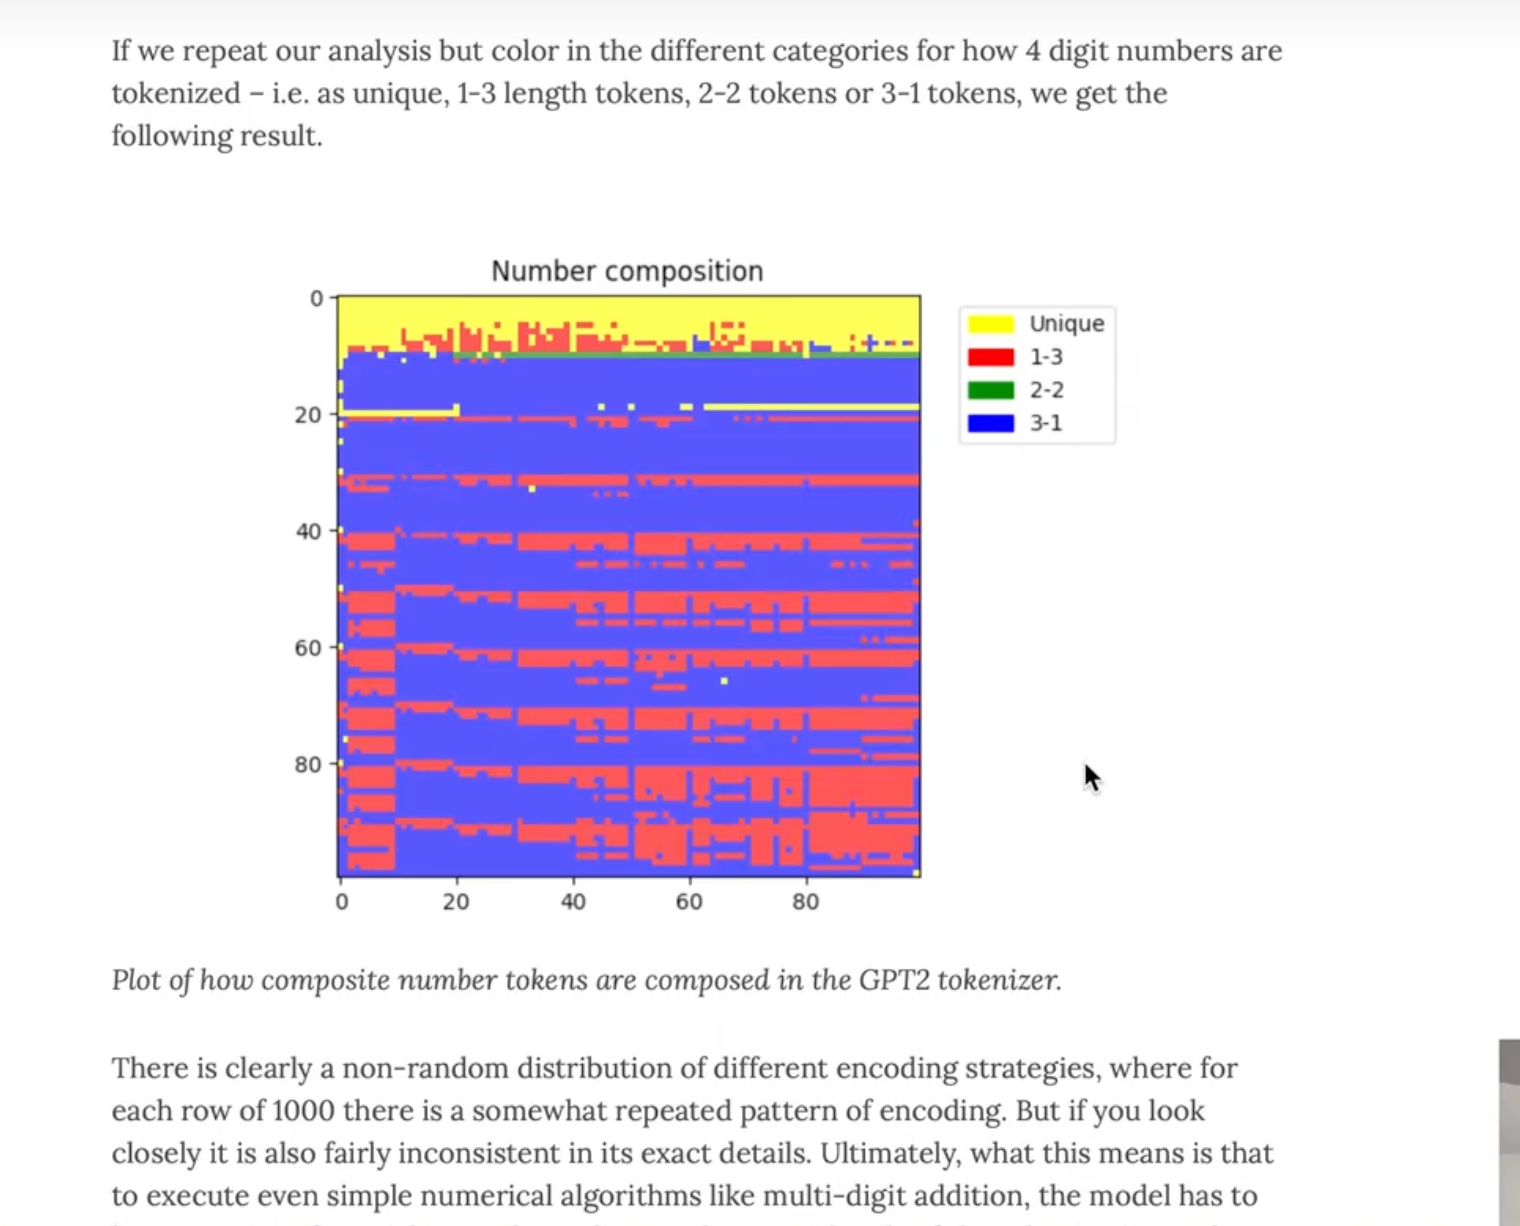。所以mata在训练lamma2时试图将数字分开，一定程度上提高简单算数类问题的表现
5. . Why did GPT-2 have more than necessary trouble coding in Python? Tokenization.
这在一定程度上是架构，数据集，模型强度的建模，部分原因也在tockenization,tockenizer在处理python空格编码的效率很差，每一个空格都单独编码为一个tocken,极大限制了模型关注上下文的能力（后面在GPT4修复）

2. Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? Tokenization.
3. What is this weird warning I get about a "trailing whitespace"? Tokenization.
4. Why the LLM break if I ask it about "SolidGoldMagikarp"? Tokenization.
5.  Why should I prefer to use YAML over JSON with LLMs? Tokenization.
6.  Why is LLM not actually end-to-end language modeling? Tokenization.
7.  What is the real root of suffering? Tokenization.

## unsrable tocken的处理
tockenizer和llm的训练数据词汇不同，可能导致一些在前者词汇表中的词汇在llm训练集中没有，导致那个标记不会被激活，当输入进llm时，由于从来未被训练就会出现一些未被定义的行为

In [ ]:
vocab = {idx: bytes([idx]) for idx in range(255)}
print(vocab)
print(vocab[3]+vocab[4]) 

b'\x03\x04'
